# Environmental parameter: $\delta_5$

According to [Cooper et al. 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.383.1058C/abstract), the $\delta_5$ parameter, or overdensity calculated by finding normalized surface density to the fifth nearest neighbor (within $\pm$1,000 km/s), is a good way to parameterize environment.

We can restrict the $\alpha.40$ catalog to $z < 0.05$ ish, which allows us to get a high-fidelity sample of $\alpha.40$ neighbors to within $z < .053$ from the [NSA catalog](http://nsatlas.org/data).

In [1]:
from astropy.io import fits
from astropy.coordinates import match_coordinates_sky, SkyCoord
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tqdm

%matplotlib inline

In [2]:
a40 = pd.read_csv('../data/a40.datafile1.csv', index_col='AGCNr')

nsa = fits.getdata('../../dusty-halos/data/nsa_v0_1_2.fits')

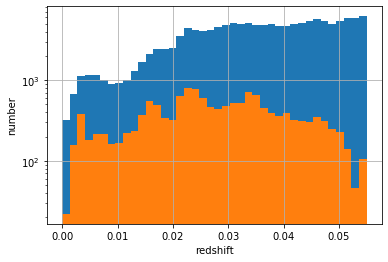

In [3]:
plt.hist(nsa['Z'], bins=40, range=[0, .055])
(a40.Dist * 70 / 3e5).hist(bins=40, range=[0, .055])
plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel('number');

In [4]:
a40.sample(3)

,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMsun,HIcode,OCcode,NoteFlag
AGCNr,,,,,,,,,,,,,,,,,
174480,NaN,114.00333,14.28472,113.99333,14.27944,8593,269,57,1.80,0.13,7.7,3.18,125.6,9.83,1,O,*
230034,NaN,195.87959,8.33333,195.87791,8.32833,6406,174,1,1.38,0.08,10.9,2.15,96.0,9.48,1,P,NaN
122215,NaN,38.36750,27.18972,38.36833,27.19472,5343,227,15,1.47,0.09,9.1,2.39,73.7,9.27,1,I,NaN


In [5]:
# get all things more than 10 Mpc away
a40_coords = a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)][['RAdeg_OC', 'DECdeg_OC']]
a40_vel = a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)]['Dist'] * 70 


In [6]:
a40_coords = SkyCoord(ra=a40_coords.RAdeg_OC, dec=a40_coords.DECdeg_OC, unit=u.deg)
nsa_coords = SkyCoord(ra=nsa['RA'], dec=nsa['DEC'], unit=u.deg)

In [7]:
# distance to fifth nearest neighbor
D_5 = []

for ra_dec, vel in tqdm.tqdm_notebook(zip(a40_coords, a40_vel), total=len(a40_vel)):
    vel_range = (nsa['z'] - 1000 < vel / 3e5) & (nsa['z'] + 1000 > vel / 3e5)
    D_5.append(match_coordinates_sky(ra_dec, nsa_coords[vel_range], nthneighbor=5)[1].deg)


KeyboardInterrupt: 

In [8]:
# 1 + delta_5, unnormalized
delta_5 = 3 / (np.pi * np.array(D_5)**2)

delta_5 /= np.median(delta_5)

Note that we can later make spatial or redshift cuts to avoid edge effects.

In [10]:
a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)].index

Int64Index([331061, 331405, 102896, 102571,  12896, 102729, 102730, 101866,
             12901, 102731,
            ...
            333443, 332890,  12882, 333224, 332891, 333253, 332895,  12885,
            331052, 333313],
           dtype='int64', name='AGCNr', length=14932)

In [25]:
overdensity = pd.DataFrame({'delta_5': delta_5.flatten()}, index=np.array(a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)].index))
overdensity.to_csv('../data/a.40-delta_5.csv')

In [29]:
np.log10(delta_5)

array([[-0.06012077],
       [-0.25919774],
       [ 0.2446192 ],
       ...,
       [-0.13916184],
       [-0.04587195],
       [-1.10127793]])

(array([  87.,   48.,   57.,   59.,   86.,  156.,  358.,  576.,  857.,
        1881., 2583., 2786., 2335., 1503.,  849.,  371.,  208.,   88.,
          34.,   10.]),
 array([-2.60001584, -2.3689326 , -2.13784936, -1.90676612, -1.67568287,
        -1.44459963, -1.21351639, -0.98243315, -0.75134991, -0.52026667,
        -0.28918343, -0.05810018,  0.17298306,  0.4040663 ,  0.63514954,
         0.86623278,  1.09731602,  1.32839926,  1.5594825 ,  1.79056575,
         2.02164899]),
 <a list of 20 Patch objects>)

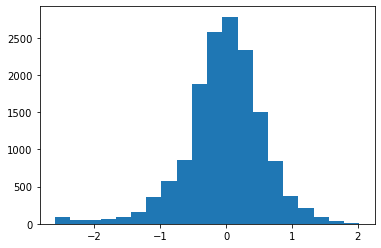

In [30]:
plt.hist(np.log10(delta_5), bins=20)
plt.xlabel(r'log(1 + $\delta_5$)')
plt.ylabel('number');

# Same thing with xGASS

In [8]:
xgass = pd.read_csv('../data/xGASS_representative_sample.csv')

In [9]:
xgass_coords = SkyCoord(ra=xgass.RA, dec=xgass.DEC, unit=u.deg)
xgass_z = xgass.zSDSS

In [10]:
xgass_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(1.9954000e-01, 14.27755), (5.0344000e-01, 15.02561),
     (5.4247000e-01, 14.1362 ), ..., (3.5828452e+02, 16.06442),
     (3.5918533e+02, 13.90986), (3.5944820e+02, 15.61368)]>

In [11]:
D_5 = []

for ra_dec, z in tqdm.tqdm_notebook(zip(xgass_coords, xgass_z), total=len(xgass_z)):
    vel_range = (nsa['z'] - 1000/3e5 < z) & (nsa['z'] + 1000/3e5 > z)
    D_5.append(match_coordinates_sky(ra_dec, nsa_coords[vel_range], nthneighbor=5)[1].deg)

In [15]:
delta_5 = 3 / (np.pi * np.array(D_5)**2)

delta_5 /= np.median(delta_5)

In [21]:
overdensity = pd.DataFrame({'delta_5': delta_5.flatten(), 'GASS': xgass.GASS})
overdensity.set_index('GASS', inplace=True, drop=True)
overdensity.to_csv('../data/xGASS-delta_5.csv', )

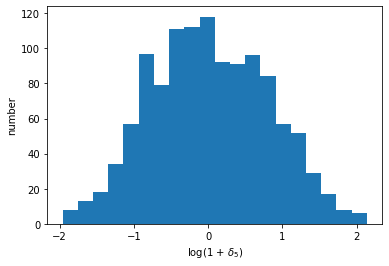

In [50]:
plt.hist(np.log10(delta_5), bins=20)
plt.xlabel(r'log(1 + $\delta_5$)')
plt.ylabel('number');

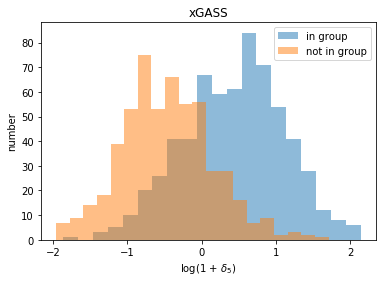

In [52]:
plt.hist(np.log10(delta_5)[xgass.env_code_B != 1], bins=20, alpha=0.5, label='in group')
plt.hist(np.log10(delta_5)[xgass.env_code_B == 1], bins=20, alpha=0.5, label='not in group')
plt.xlabel(r'log(1 + $\delta_5$)')
plt.ylabel('number');

plt.title('xGASS')
plt.legend();